In [1]:
###### Importacao de Libs Necessárias

import pandas as pd
from sklearn.model_selection import train_test_split
import datetime
import numpy as np
from xgboost import XGBRegressor
import sklearn.model_selection as ms
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
import shap




ModuleNotFoundError: No module named 'xgboost'

In [14]:
base_full = pd.read_csv('base_final_fundos.csv',sep=";",decimal=",")
print(base_full.shape)

(136294, 66)


In [6]:
base_analise = base_full.drop(columns=['date','cod_cnpj','prim_key','Unnamed: 0', 'Unnamed: 0.1',
                                      #'vl_cota_d5','vl_cota_d4','vl_cota_d3','vl_cota_d2','vl_cota_d1'
                                      ])


# base_analise=base_analise[ ['vl_cota','vl_cota_d3','selic','bovespa','dolar','dow_30','ipca_15','tx_cambio',
#                            'netEquity', 'manager.netEquity',
#                            'investmentConditions.administrationRate',
#                            'investmentConditions.performanceRate', 'is_suggested_0',
#                            'is_suggested_1', 'Fundo de Investimento Cambial',
#                            'Fundo de Investimento Multimercado',
#                            'Fundo de Investimento Renda Fixa', 'Fundo de Investimento em Ações',
#                            'Fundo de Investimento no Exterior'] ]
# base_analise = base_analise[base_analise['Fundo de Investimento Multimercado']==1]
base_analise= base_analise.sample(frac=1)

X = base_analise.drop(columns=['vl_cota']).reset_index(drop=True)
X = X.apply(pd.to_numeric)
Y = base_analise.pop('vl_cota').reset_index(drop=True)
Y = Y.apply(pd.to_numeric)


In [7]:
xgb  = XGBRegressor()
params = {'nthread':[4], 
              #'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100]}
clf = RandomizedSearchCV(xgb, param_distributions=params, n_iter=1, scoring='neg_mean_squared_error', n_jobs=10)



In [8]:
nfolds = 5
cv = ms.KFold(n_splits=nfolds, shuffle=True)
estimators = []
mses = []
train_indexes = {}
test_indexes = {}
score = 0.0
current_fold = 0
results = np.zeros(len(X)) #### Resultados das predições


for train_index, test_index in cv.split(X):
    print(current_fold)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    print("training...")
    clf.fit(X_train, y_train)
    estimators.append(clf.best_estimator_)
    print("Predict...")
    y_pred = clf.predict(X_test)
    #y_pred = [x[1] for x in y_pred]
    mses.append(mean_squared_error(y_test, y_pred))
    train_indexes.update({str(current_fold): train_index})
    test_indexes.update({str(current_fold): test_index})
    current_fold+=1

0
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
1
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
2
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
3
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
4
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...


In [10]:
print(mses)
print(np.mean(mses))

[3.8221646526554593, 147.58994112629196, 7.7481821093114505, 7.455748105968421, 4.962473649952885]
34.315701928836035


In [12]:
fts_importance = pd.DataFrame(data = np.transpose(np.array([X.columns , estimators[1].feature_importances_])),
                              columns = ['feature','importance'])
fts_importance = fts_importance.sort_values(by =  'importance' , ascending = False)
fts_importance.head(15)

,feature,importance
1,vl_cota_d2,0.251594
0,vl_cota_d1,0.238009
2,vl_cota_d3,0.130498
43,tx_cambio_d2,0.110964
3,vl_cota_d4,0.103479
4,vl_cota_d5,0.0591805
25,dolar_d2,0.0545456
8,dolar,0.0192058
5,vl_cota_d6,0.0188709
26,dolar_d3,0.00771948


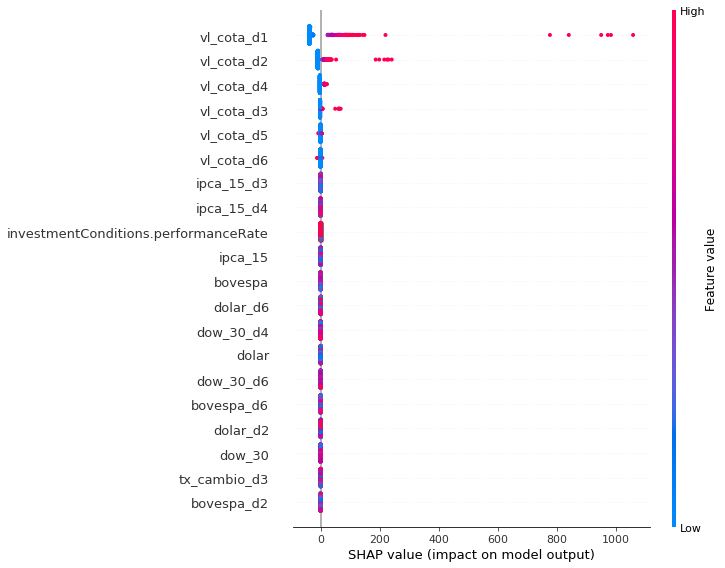

In [13]:
test = X.iloc[train_indexes['0']].sample(frac=1)[1:500]
explainer = shap.TreeExplainer(estimators[0],feature_dependence='independent')
shap_values = explainer.shap_values(test,approximate=True,tree_limit = 50)
shap.summary_plot(shap_values, test)
